<a href="https://colab.research.google.com/github/Ashi743/pytorch/blob/main/CNN_basic_campusx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

#print("Path to dataset files:", path)

for filename in os.listdir(path):
  if filename.endswith('csv'):

    csv_filepath= os.path.join(path, filename)

    print(csv_filepath)

100%|██████████| 68.8M/68.8M [00:04<00:00, 17.5MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv


In [2]:
# eda
import pandas as pd
train= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv")
test = pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv")

In [3]:
#device check
import torch
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


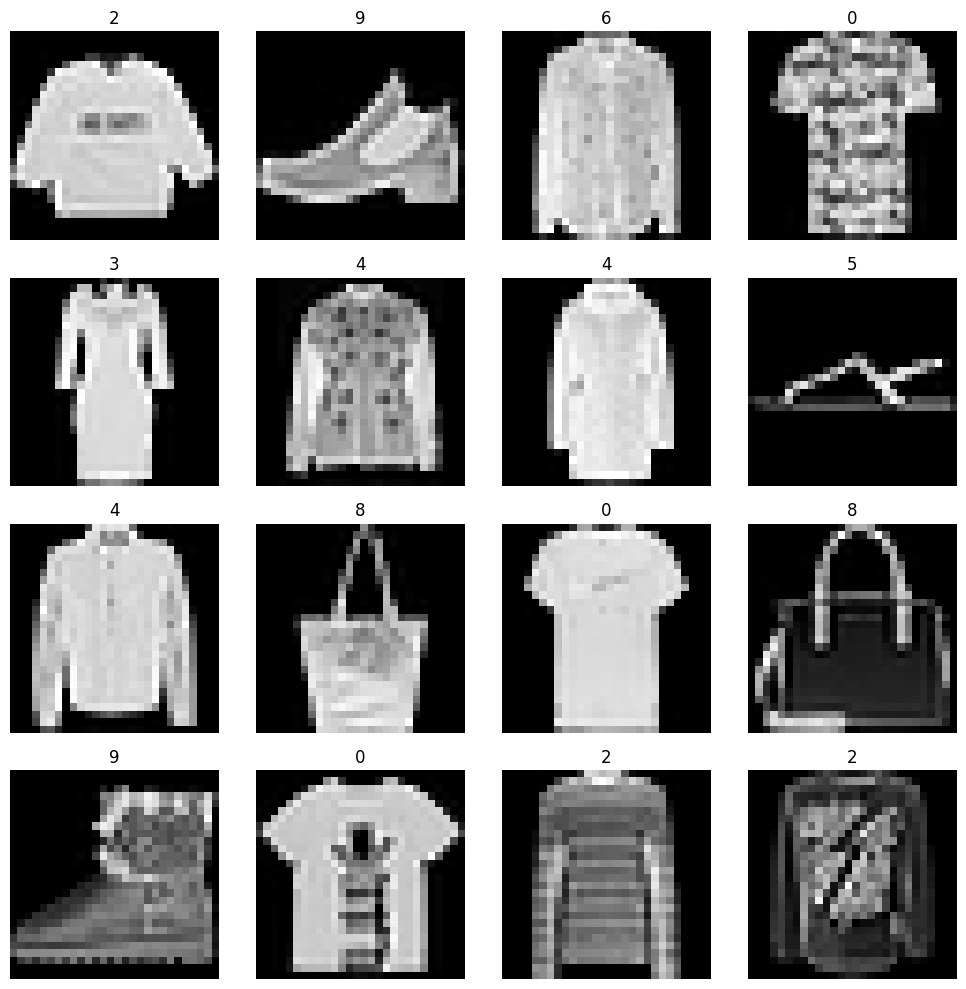

In [5]:
# data exploration
import matplotlib.pyplot as plt
import numpy as np
fig, ax= plt.subplots(ncols=4, nrows= 4, figsize= (10,10))
for i, ax in enumerate(ax.flatten()):  #to flatten 4x4 into 0-15
  img= train.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img, cmap= 'grey')
  ax.axis('off')
  ax.set_title(train.iloc[i,0])
plt.tight_layout()
plt.show()

In [6]:
X_train= train.iloc[:, 1:].values   # to get values not the df
Y_train= train.iloc[:, 0 ].values

X_test= test.iloc[:, 1:].values   # to get values not the df
Y_test= test.iloc[:, 0 ].values

#scaling

X_train_scaled= X_train/255
X_test_scaled = X_test/255

In [7]:
from torch.utils.data import Dataset, DataLoader
# to get rows from dataset
# to load batchwise data from dataset via dataloader
class customdataset(Dataset):
  def __init__(self, features, label) -> None:
    self.features= torch.tensor(features, dtype= torch.float32).reshape(-1,1,28,28)
    self.label   = torch.tensor(label   , dtype= torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.label[index]

#dataset
train_dataset= customdataset(X_train,Y_train)
test_dataset = customdataset(X_test, Y_test)

#dataloader
train_dataloader= DataLoader(train_dataset , batch_size= 32, shuffle= True,  pin_memory= True)
test_dataloader = DataLoader(test_dataset  , batch_size= 32, shuffle =False, pin_memory= True)

In [12]:
# NN ARCH
from torch import nn
import torch.optim as optim
class mycnn(nn.Module):
  def __init__(self, input_channels):
    super().__init__()

    #FEATURE LAYER
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                  out_channels= 32,
                  kernel_size=3,
                  padding='same')  ,
        nn.ReLU(),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(kernel_size =2, stride=2),

        nn.Conv2d(in_channels=  32,
                  out_channels= 64,
                  kernel_size=3,
                  padding='same')  ,
        nn.ReLU(),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(kernel_size =2, stride=2)
    )

    #CLASSIFICATION LAYER
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= 64*7*7 ,
                  out_features= 128 ),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p= 0.4),

        nn.Linear(in_features= 128,
                  out_features= 64 ),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p= 0.4),

        nn.Linear(in_features=64,
                  out_features=10)
    )

  def forward(self, x):
    x= self.features(x)
    x= self.classifier(x)
    return x

In [24]:
lr= 0.01
epochs= 50

In [25]:
model= mycnn(input_channels= 1)
model.to(device)

loss= nn.CrossEntropyLoss()
optimizer= optim.SGD(model.parameters(), lr, weight_decay=1e-4)

In [26]:
#trainig loop
for epoch in range(epochs):
  total_epoch_loss= 0
  for batch_features, batch_label in train_dataloader:
    batch_features, batch_label= batch_features.to(device), batch_label.to(device)

    output= model(batch_features)
    loss_= loss(output, batch_label)

    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()

    total_epoch_loss+=loss_.item()

  avg_loss= total_epoch_loss/ len(train_dataloader)
  print(f'epoch: {epoch+1}, loss; {avg_loss}')



epoch: 1, loss; 0.6566975288152694
epoch: 2, loss; 0.4019689535816511
epoch: 3, loss; 0.3466722652633985
epoch: 4, loss; 0.3091674077153206
epoch: 5, loss; 0.2858291851023833
epoch: 6, loss; 0.2658867042839527
epoch: 7, loss; 0.25137412596742315
epoch: 8, loss; 0.2399909252256155
epoch: 9, loss; 0.22696706107159456
epoch: 10, loss; 0.21737428176303705
epoch: 11, loss; 0.2066998725016912
epoch: 12, loss; 0.19470771630605063
epoch: 13, loss; 0.18571467657486598
epoch: 14, loss; 0.18168387827078503
epoch: 15, loss; 0.17399594333221516
epoch: 16, loss; 0.1683610121011734
epoch: 17, loss; 0.15992355408320824
epoch: 18, loss; 0.15376081897616387
epoch: 19, loss; 0.14980107008467117
epoch: 20, loss; 0.14341702849119903
epoch: 21, loss; 0.13761696840276322
epoch: 22, loss; 0.13256463205466668
epoch: 23, loss; 0.130126280948023
epoch: 24, loss; 0.12407216878384351
epoch: 25, loss; 0.12307236871918042
epoch: 26, loss; 0.11824990734532476
epoch: 27, loss; 0.11024269804308812
epoch: 28, loss; 0.10

In [27]:
model.eval()

mycnn(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReL

In [28]:
#on train data
total= 0
correct =0
with torch.no_grad():
  for batch_features, batch_label in train_dataloader:
    batch_features, batch_label= batch_features.to(device), batch_label.to(device)

    output= model(batch_features)

    _, predicted= torch.max(output, 1)
    total+=batch_label.shape[0]
    correct+=(predicted==batch_label).sum().item()

  print(f'accuracy: {correct/total}')


accuracy: 0.9969166666666667


In [29]:
# on test data
total= 0
correct =0
with torch.no_grad():
  for batch_features, batch_label in test_dataloader:
    batch_features, batch_label= batch_features.to(device), batch_label.to(device)

    output= model(batch_features)

    _, predicted= torch.max(output, 1)
    total+=batch_label.shape[0]
    correct+=(predicted==batch_label).sum().item()

  print(f'accuracy: {correct/total}')


accuracy: 0.9275
